In [5]:
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
from torch.utils.data import Dataset
import os
import torch
from transformers import AdamW, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from transformers.optimization import get_scheduler
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoModelForMaskedLM
from torch.nn.functional import softmax
import warnings
import torchinfo
from bertviz import head_view
import openai
import requests
import time
import praw

In [9]:
Client_ID = "client_id"
Secret_Key = "client_secret"

In [10]:
auth = requests.auth.HTTPBasicAuth(Client_ID, Secret_Key)
data = {
    'grant_type': 'password',
    'username': 'username',
    'password': 'password'
}
headers = {"User-Agent": "MyAPI/0.0.1"}
res = requests.post('https://www.reddit.com/api/v1/access_token', auth=auth, data=data, headers=headers)
TOKEN = res.json()['access_token']
headers['Authorization'] = f'bearer {TOKEN}'

In [11]:
# Function to make a Reddit API request and check rate limit headers
def check_rate_limit():
    # Reddit API endpoint URL
    url = 'https://oauth.reddit.com'
    # Make a Reddit API request
    response = requests.get(url, headers=headers)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Print the rate limit headers
        print('Rate Limit Headers:')
        print('X-Ratelimit-Used:', response.headers.get('X-Ratelimit-Used'))
        print('X-Ratelimit-Remaining:', response.headers.get('X-Ratelimit-Remaining'))
        print('X-Ratelimit-Reset:', response.headers.get('X-Ratelimit-Reset'))
    else:
        print('Error:', response.status_code)

# Call the function to check rate limit
check_rate_limit()

Rate Limit Headers:
X-Ratelimit-Used: 1
X-Ratelimit-Remaining: 599.0
X-Ratelimit-Reset: 305


In [12]:
# Initialize Reddit API instance
reddit = praw.Reddit(
    client_id='client_id',
    client_secret='client_secret',
    user_agent = 'MyAPI/0.0.1'
)

In [64]:

# Define subreddit to scrape
subreddit_name = 'all'  # 'all' for scraping from all subreddits, or specify a particular subreddit

# Define keyword to search for in posts and comments
keyword = 'clinical trial'

# Function to scrape posts and comments containing the keyword
def scrape_reddit(keyword, subreddit_name):
    # Create empty lists to store data
    data = {'Post Title': [], 'Post Text': [], 'Comment': []}

    # Scrape posts
    for post in reddit.subreddit(subreddit_name).search(keyword, sort='new', syntax='lucene', time_filter='year',limit = 10):
        data['Post Title'].append(post.title)
        data['Post Text'].append(post.selftext)

        # Scrape comments for each post
        post.comments.replace_more(limit=None)
        for comment in post.comments.list():
            data['Comment'].append(comment.body)

    return data

# Call function to scrape Reddit
reddit_data = scrape_reddit(keyword, subreddit_name)

In [15]:
# Define subreddit to scrape
subreddit_name = 'all'  # 'all' for scraping from all subreddits, or specify a particular subreddit

# Define keyword to search for in posts and comments
keyword = 'clinical trial'

def scrape_reddit(keyword, subreddit_name):
    # Create a list to store post data
    data = []

    # Scrape posts
    for post in reddit.subreddit(subreddit_name).search(keyword, sort='new', syntax='lucene', time_filter='year', limit=1000):
        print("Scraping post:", post.title)
        
        # Create a dictionary for each post
        post_data = {
            'Post Title': post.title,
            'Post Text': post.selftext,
            'Comments': []
        }

        # Scrape comments for each post
        post.comments.replace_more(limit=None)
        for comment in post.comments.list():
            # Append each comment as a dictionary to maintain context
            post_data['Comments'].append({'Comment Body': comment.body})

        # Append the post data to the main data list
        data.append(post_data)

    return data

# Call function to scrape Reddit
reddit_data = scrape_reddit(keyword, subreddit_name)

Scraping post: Open Compensated Clinical Study for adults w/SC
Scraping post: 📩 Clinical Trial Lead/Clinical Research Associate at 🏢 VIAL. Salary: 💰$90,000 - $95,000. 📍Remote job in 🇺🇸 United States
Scraping post: Reverse Split
Scraping post: Why don't more people seemingly know about the "alternative treatments" for various conditions per se, and the perspectives, there associated, vis. items like depression etc.?
Scraping post: Recent clinical trial shows significant improvement in fibromyalgia symptoms of fatigue and pain.
Scraping post: Recent clinical trial shows significant improvement in fibromyalgia symptoms of fatigue and pain. 
Scraping post: PRISM MarketView Highlights Soligenix, Inc. as it Builds on Compelling Phase 3 Data with Key Catalysts on the Horizon
Scraping post: TRIUMPH-3 🇦🇺 cardiovascular/obesity update
Scraping post: Spoke w/ VMR Institute about FOV
Scraping post: my dog won't gain weight 
Scraping post: BDRX | Positive Statistically Significant Phase 2 Clinical 

In [17]:
# Assuming reddit_data is a list of dictionaries as per your updated scraping function
post_count = len(reddit_data)  # Number of posts
post_text_count = sum(1 for post in reddit_data if post['Post Text'])  # Number of non-empty post texts
comments_count = sum(len(post['Comments']) for post in reddit_data)  # Total number of comments

print(f"Number of Post Titles: {post_count}")
print(f"Number of Post Texts: {post_text_count}")
print(f"Total Number of Comments: {comments_count}")

Number of Post Titles: 250
Number of Post Texts: 213
Total Number of Comments: 1981


In [67]:
print("(1) # Check values for each key")
for key, value in reddit_data.items():
    if value:  # Check if the value list is not empty
        print(f"{key}: {value[1]}")
    else:
        print(f"{key}: No data available")

(1) # Check values for each key
Post Title: The Apology Of Chris To The World Of Placebo

Post Text: Months ago, I wrote this post ([Why Do Non-fans Hate Placebo & The Soulmates?](https://www.reddit.com/r/placebo/comments/1ci7klo/why_do_nonfans_hate_placebo_the_soulmates/)). In it, I related my kean observations on how the outside world hates Placebo so much. For they indeed hate Brian, Stefi, the band, and the Solemates. They cast such fowel names upon us and say we are mentally unrested, dirty, pale, unwell, et cetera. Because of Brian's Nancy-boy days, they assault him still, claming he is a sexy, sweaty girl who masquerades as a man with a ridiculous false mustache; and for Steff, they make him out to be the Swedish Elephant-man, although in reality, Stef is merely real tall and nothing else unusual. 

[The enemies of Placebo compartmentalize Brian in a clear box](https://preview.redd.it/o3qctcvcdxzc1.jpg?width=1024&format=pjpg&auto=webp&s=462b8fef3276419e7ab1554614a8b3956ed0b850)


In [ ]:
def scrape_subreddit(subreddit_name):
    # Create empty lists to store data
    data = {'Post Title': [], 'Post Text': [], 'Comments': []}

    # Scrape posts
    for post in reddit.subreddit(subreddit_name).new(limit=None):
        print("Scraping post:", post.title)
        data['Post Title'].append(post.title)
        data['Post Text'].append(post.selftext)

        # Scrape comments for each post
        post.comments.replace_more(limit=None)
        #comments = []
        for comment in post.comments.list():
            data['Comments'].append(comment.body)

        #data['Comments'].append(comments)

        # Introduce a delay between requests to avoid rate limiting
        time.sleep(2)  # Adjust delay as needed

    return data

# Call function to scrape subreddit for each subreddit
FindClinTrial = scrape_subreddit('FindClinTrial')
ClinTrialExplain = scrape_subreddit('ClinTrialExplain')
clinicaltrials = scrape_subreddit('clinicaltrials')
#ClinTrials = scrape_subreddit('ClinTrials')
clinicaltrialsunit = scrape_subreddit('clinicaltrialsunit')
researchclinics = scrape_subreddit('researchclinics')

In [13]:
def scrape_subreddit(subreddit_name):
    # Create a list to store post data
    data = []

    # Scrape posts
    for post in reddit.subreddit(subreddit_name).new(limit=None):
        print("Scraping post:", post.title)
        
        # Create a dictionary for each post
        post_data = {
            'Post Title': post.title,
            'Post Text': post.selftext,
            'Comments': []
        }

        # Scrape comments for each post
        post.comments.replace_more(limit=None)
        for comment in post.comments.list():
            # Append each comment as a dictionary to maintain context
            post_data['Comments'].append({'Comment Body': comment.body})

        # Append the post data to the main data list
        data.append(post_data)

        # Introduce a delay between requests to avoid rate limiting
        time.sleep(2)  # Adjust delay as needed

    return data

# Call function to scrape subreddit for each subreddit
FindClinTrial = scrape_subreddit('FindClinTrial')
ClinTrialExplain = scrape_subreddit('ClinTrialExplain')
clinicaltrials = scrape_subreddit('clinicaltrials')
#ClinTrials = scrape_subreddit('ClinTrials')
clinicaltrialsunit = scrape_subreddit('clinicaltrialsunit')
researchclinics = scrape_subreddit('researchclinics')

Scraping post: The Future of Clinical Trials
Scraping post: How to Protect Your Privacy When Participating in a Clinical Trial?
Scraping post: Where to Find Clinical Trials?
Scraping post: How to Talk to Your Doctor About Clinical Trials?
Scraping post: The Risks of Participating in a Clinical Trial
Scraping post: The Benefits of Participating in a Clinical Trial
Scraping post: Everything You Need to Know About Clinical Trials
Scraping post: The 10-Step Guide to Finding a Clinical Trial
Scraping post: How to Find Clinical Trials That Are Right for You?
Scraping post: How to Find Clinical Trials for Your Condition?
Scraping post: How to participate in a clinical trial?
Scraping post: AbbVie's NCT04432849 trial:
Scraping post: Gilead Sciences' NCT04437843 trial:
Scraping post: Novartis' NCT04442672 trial
Scraping post: Pfizer's NCT04459878 clinical trial
Scraping post: Merck's NCT04483829 trial:
Scraping post: Roche's NCT04506040 trial
Scraping post: Vertex Pharmaceuticals' NCT04536494 c

In [ ]:
# Combine the data into one dictionary
subreddit_data = {
    'Post Title': FindClinTrial['Post Title'] + ClinTrialExplain['Post Title'] +
                  clinicaltrials['Post Title'] +
                  clinicaltrialsunit['Post Title'] + researchclinics['Post Title'] + reddit_data['Post Title'],
    'Post Text': FindClinTrial['Post Text'] + ClinTrialExplain['Post Text'] +
                 clinicaltrials['Post Text'] +
                 clinicaltrialsunit['Post Text'] + researchclinics['Post Text']+ reddit_data['Post Text'],
    'Comment': FindClinTrial['Comments'] + ClinTrialExplain['Comments'] +
               clinicaltrials['Comments'] +
               clinicaltrialsunit['Comments'] + researchclinics['Comments']+ reddit_data['Comment']
}

In [18]:
# Initialize empty lists to hold combined data
combined_post_titles = []
combined_post_texts = []
combined_comments = []

# Function to extract and combine data from subreddit dictionaries
def combine_data(*subreddit_dicts):
    for subreddit_dict in subreddit_dicts:
        for post in subreddit_dict:
            combined_post_titles.append(post['Post Title'])
            combined_post_texts.append(post['Post Text'])
            # Extract comments from each post's 'Comments' list
            for comment in post['Comments']:
                combined_comments.append(comment['Comment Body'])

# Combine data from all subreddit dictionaries
combine_data(FindClinTrial, ClinTrialExplain, clinicaltrials, clinicaltrialsunit, researchclinics, reddit_data)

# Create the final combined dictionary
subreddit_data = {
    'Post Title': combined_post_titles,
    'Post Text': combined_post_texts,
    'Comment': combined_comments
}

In [19]:
# Check lengths of arrays
for key, value in subreddit_data.items():
    print(f"Length of {key}: {len(value)}")

Length of Post Title: 395
Length of Post Text: 395
Length of Comment: 2030


In [20]:
# Extracting lists of post text and comments
post_texts = subreddit_data['Post Text']
comments = subreddit_data['Comment']
final = post_texts + comments
# Printing the lists
print("List of Post Texts:")
print(len(post_texts))
print("\nList of Comments:")
print(len(comments))

List of Post Texts:
395

List of Comments:
2030


In [21]:
# Convert the list of lists into a DataFrame
df = pd.DataFrame(final)
df.rename(columns={df.columns[0]: 'text'}, inplace=True)
df.head()
# Save the DataFrame as a CSV file
df.to_csv('scrapped_data.csv', index=False)

In [38]:
df = pd.read_csv("scrapped_data.csv")
# Strip whitespace from 'text' column
df['text'] = df['text'].str.strip()

# Drop rows where 'text' column is empty
df.drop(df[df['text'] == ""].index, inplace=True)

def preprocess_text(text):
    if isinstance(text, list):
        # Convert the list to a string
        text = ' '.join(text)
    # Remove non-alphabetic characters using regular expression
    processed_text = re.sub('[^a-zA-Z]', ' ', text)
    return processed_text

# Apply the preprocessing function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)
df.head()

# Lowercasing
df['text'] = df['text'].str.lower()
df.head()

text
0  the future of clinical trials is bright  with ...
1  protecting your privacy when participating in ...
2  there are many places where you can find clini...
3  discussing the possibility of participating in...
4  participating in a clinical trial can offer be...

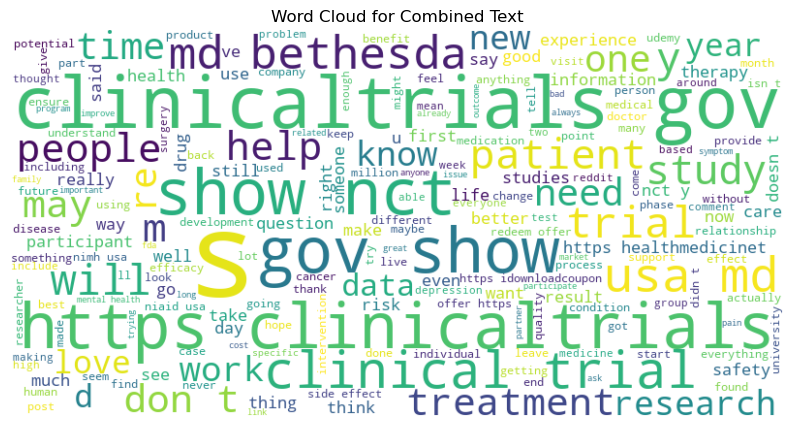

In [39]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['text']))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Combined Text')
plt.axis('off')
plt.show()

In [40]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Create an empty 'opinion' column
df['opinion'] = ""

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Get the text from the 'text' column
    text = row['text']

    # Get polarity scores using VADER
    scores = analyzer.polarity_scores(text)

    # Determine label based on compound score
    if scores['compound'] >= 0.05:
        label = 'positive'
    elif scores['compound'] <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'

    # Save the sentiment to the 'opinion' column
    df.at[index, 'opinion'] = label

# Now your DataFrame df has a new column 'opinion' containing the sentiment predictions using VADER

In [41]:
df.head()

text   opinion
0  the future of clinical trials is bright  with ...  positive
1  protecting your privacy when participating in ...  positive
2  there are many places where you can find clini...  positive
3  discussing the possibility of participating in...  positive
4  participating in a clinical trial can offer be...  positive

In [42]:
positives_count = df['opinion'].value_counts().get('positive', 0)
negatives_count = df['opinion'].value_counts().get('negative', 0)

print("Number of positive opinions:", positives_count)
print("Number of negative opinions:", negatives_count)

Number of positive opinions: 1145
Number of negative opinions: 454


In [43]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [45]:
# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['opinion'], test_size=0.2)

# Load ClinicalBERT model and tokenizer
model_name = "medicalai/ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Tokenize data with maximum length
max_length = 512  # Set the maximum length
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=max_length)

# Convert labels to numerical format
label_map = {'positive': 1, 'negative': 0, 'neutral': 2}  # Define mapping for positive, negative, and neutral labels
train_labels = [label_map.get(label, -1) for label in train_labels]  # Assign -1 to unknown labels
val_labels = [label_map.get(label, -1) for label in val_labels]  # Assign -1 to unknown labels

# Filter out instances with unknown labels (-1)
train_texts_filtered = [text for text, label in zip(train_texts, train_labels) if label != -1]
train_labels_filtered = [label for label in train_labels if label != -1]
val_texts_filtered = [text for text, label in zip(val_texts, val_labels) if label != -1]
val_labels_filtered = [label for label in val_labels if label != -1]

# Convert labels to tensor
train_labels_tensor = torch.tensor(train_labels_filtered)
val_labels_tensor = torch.tensor(val_labels_filtered)

# Define Trainer
output_dir = "./output_dir"  # Specify output directory where trained model and logs will be saved

# Define early stopping
early_stopping_patience = 3
early_stopping = EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)

# Define optimizer
learning_rate = 2e-5  # Choosing a default learning rate from the defined list
weight_decay = 0.001  # Choosing a default weight decay from the defined list
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=learning_rate,
    lr_scheduler_type="cosine_with_restarts",
    weight_decay=weight_decay,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    evaluation_strategy="steps",  # Change evaluation strategy to steps
    save_strategy="steps",         # Change save strategy to steps
    logging_steps=10,
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=CustomDataset(train_encodings, train_labels),
    eval_dataset=CustomDataset(val_encodings, val_labels),    
    callbacks=[early_stopping],
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()

# Save the trained model and tokenizer in the output directory
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Save the trained model
torch.save(model.state_dict(), os.path.join(output_dir, "fine_tuned_model.pth"))
print("Trained model saved at:", output_dir)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trained model saved at: ./output_dir


In [ ]:
# VADER Sentiment Analysis (for label generation)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Create sentiment labels
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['opinion'] = df['text'].apply(get_sentiment)

# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['opinion'], test_size=0.2, stratify=df['opinion'])

# Convert labels to numerical format
label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
train_labels = [label_map[label] for label in train_labels]
val_labels = [label_map[label] for label in val_labels]

# Oversample the minority class in the training set
ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(pd.DataFrame({'text': train_texts}), pd.DataFrame({'label': train_labels}))

# Convert back to lists
train_texts_resampled = train_texts_resampled['text'].tolist()
train_labels_resampled = train_labels_resampled['label'].tolist()

# Load ClinicalBERT model and tokenizer
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize data with maximum length
max_length = 512
train_encodings = tokenizer(train_texts_resampled, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=max_length)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = CustomDataset(train_encodings, train_labels_resampled)
val_dataset = CustomDataset(val_encodings, val_labels)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=[0, 1, 2], y=train_labels_resampled)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Define Trainer arguments
training_args = TrainingArguments(
    output_dir='./output_dir',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    evaluation_strategy="steps",
    save_steps=50,
    eval_steps=50,
    logging_steps=100,
    learning_rate=1e-5,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# Define custom Trainer class to handle class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Early stopping callback
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# Initialize Trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping],
    optimizers=(AdamW(model.parameters(), lr=1e-5), None)
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()
print("Evaluation results:", eval_result)

# Save the trained model and tokenizer
model.save_pretrained('./output_dir')
tokenizer.save_pretrained('./output_dir')

# Save model state
torch.save(model.state_dict(), './output_dir/fine_tuned_model.pth')
print("Trained model saved at:", './output_dir')

In [10]:
# Call function to scrape subreddit for each subreddit
Diabetes = scrape_subreddit('diabetes')


Scraping post: One Issue After Another
Scraping post: Diabetes related book recommendations
Scraping post: Cheat meals
Scraping post: Ozempic migraines?
Scraping post: Dexcom7 misbehaving?
Scraping post: Newly Diagnosed 40 Year Old with T2D. (Previous Post deleted due to misleading Typo)
Scraping post: I think my glucose is flipping me off
Scraping post: Insulin injections
Scraping post: I’m 28M, & was just told I’m prediabetic & A1C is high. Obviously lifestyle changes are needed. But- 
Scraping post: Long shot here
Scraping post: Libre2 sensor fell off
Scraping post: Weird symptoms
Scraping post: Request
Scraping post: Furious with my insurance.
Scraping post: What are your favourite store-bought snacks that are diabetic friendly?
Scraping post: Newly diagnosed with T1D - in need of a rant...
Scraping post: hyperglycemia weight loss
Scraping post: What food was the hardest to give up after diagnosis of t1d
Scraping post: Anyone else have a faulty T:Slim cartridge ?
Scraping post: Wha

In [12]:
# Check lengths of arrays
for key, value in Diabetes.items():
    print(f"Length of {key}: {len(value)}")

Length of Post Title: 996
Length of Post Text: 996
Length of Comments: 15043


In [14]:
# Extracting lists of post text and comments
post_texts = Diabetes['Post Text']
comments = Diabetes['Comments']
final = post_texts + comments
# Printing the lists
print("List of Post Texts:")
print(len(post_texts))
print("\nList of Comments:")
print(len(comments))

List of Post Texts:
996

List of Comments:
15043


In [15]:
# Convert the list of lists into a DataFrame
df = pd.DataFrame(final)
df.head()

0
0  Just a friendly reminder that when you're goin...
1  I want to read some books about diabetes to un...
2  Do you consider it important psychologically t...
3  I have a history of migraines but ironically f...
4           Or is sugar really jumping up and down?

In [16]:
df.rename(columns={df.columns[0]: 'text'}, inplace=True)
df.head()

text
0  Just a friendly reminder that when you're goin...
1  I want to read some books about diabetes to un...
2  Do you consider it important psychologically t...
3  I have a history of migraines but ironically f...
4           Or is sugar really jumping up and down?

In [16]:

# Save the DataFrame as a CSV file
df.to_csv('diabetes_data.csv', index=False)

In [46]:
df = pd.read_csv("diabetes_data.csv")

In [47]:
# Display basic information about the DataFrame
print("Shape of the DataFrame:", df.shape)
print("\nColumn-wise Information:")
print(df.info())

Shape of the DataFrame: (1868, 1)

Column-wise Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868 entries, 0 to 1867
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1868 non-null   object
dtypes: object(1)
memory usage: 14.7+ KB
None


In [48]:
df.head()

text
0  the future of clinical trials is bright  with ...
1  protecting your privacy when participating in ...
2  there are many places where you can find clini...
3  discussing the possibility of participating in...
4  participating in a clinical trial can offer be...

In [20]:
# Check for empty rows
empty_rows = df[df['text'].fillna("").apply(lambda x: str(x).strip()) == ""]
print("\nNumber of Empty Rows:", len(empty_rows))


Number of Empty Rows: 7


In [21]:
# Strip whitespace from 'text' column
df['text'] = df['text'].str.strip()

# Drop rows where 'text' column is empty
df.drop(df[df['text'] == ""].index, inplace=True)

In [22]:
# Check for empty rows
empty_rows = df[df['text'].apply(lambda x: str(x).strip()) == ""]
print("\nNumber of Empty Rows:", len(empty_rows))


Number of Empty Rows: 0


In [23]:
def preprocess_text(text):
    if isinstance(text, list):
        # Convert the list to a string
        text = ' '.join(map(str, text))
    elif isinstance(text, float):
        # Handle NaN values
        return ""
    # Remove non-alphabetic characters using regular expression
    processed_text = re.sub('[^a-zA-Z]', ' ', text)
    return processed_text

# Apply the preprocessing function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)
df.head()

text   opinion
0  the future of clinical trials is bright  with ...  positive
1  protecting your privacy when participating in ...  positive
2  there are many places where you can find clini...  positive
3  discussing the possibility of participating in...  positive
4  participating in a clinical trial can offer be...  positive

In [24]:
# Lowercasing
df['text'] = df['text'].str.lower()
df.head()

text   opinion
0  the future of clinical trials is bright  with ...  positive
1  protecting your privacy when participating in ...  positive
2  there are many places where you can find clini...  positive
3  discussing the possibility of participating in...  positive
4  participating in a clinical trial can offer be...  positive

In [26]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Load ClinicalBERT model and tokenizer
model_name = "medicalai/ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# Load the saved state dictionary
model_state_dict = torch.load("fine_tuned_model.pth")
# Update the model parameters with the saved state dictionary
model.load_state_dict(model_state_dict)

# Function to perform sentiment analysis on a single text
def analyze_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Check if the input sequence length exceeds the maximum allowed length
    if inputs.input_ids.shape[1] > 512:
        # Truncate the input sequence to the maximum allowed length
        inputs.input_ids = inputs.input_ids[:, :512]
        inputs.attention_mask = inputs.attention_mask[:, :512]

    # Pass the inputs through the model
    outputs = model(**inputs)
    
    # Compute softmax probabilities for sentiment classification
    probs = softmax(outputs.logits, dim=1)
    
    # Map predicted sentiment index to labels
    sentiment_labels = ['positive', 'negative','neutral']
    predicted_sentiment_index = torch.argmax(probs, dim=1)
    predicted_sentiment = sentiment_labels[predicted_sentiment_index]
    
    return predicted_sentiment, {label: prob for label, prob in zip(sentiment_labels, probs.squeeze().tolist())}

# Apply sentiment analysis to the DataFrame
sentiments = []
probabilities = []
for text in df['text']:
    print(text)
    sentiment, probs = analyze_sentiment(text)
    print(sentiment, probs)
    sentiments.append(sentiment)
    probabilities.append(probs)

# Add sentiment and probability columns to the DataFrame
df['sentiment'] = sentiments
df['sentiment_probabilities'] = probabilities

# Save the DataFrame with sentiment analysis results
df.to_csv("sentiment_analysis_results.csv", index=False)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


the future of clinical trials is bright  with many exciting trends on the horizon  here are some of the most promising trends to watch for       decentralized trials    decentralized trials  dcts  are a type of clinical trial that is conducted remotely  with patients participating from their homes or other convenient locations  dcts offer a number of advantages over traditional clinical trials  including increased patient convenience  reduced costs  and improved recruitment and retention rates      wearable devices    wearable devices  such as fitness trackers and smartwatches  are increasingly being used in clinical trials to collect data on patient health and activity levels  this data can be used to monitor patients  progress over time and to identify potential side effects      artificial intelligence  ai     ai is being used in clinical trials to automate tasks  such as data analysis and patient recruitment  ai can also be used to develop new algorithms for predicting patient outc

In [49]:
df = pd.read_csv("sentiment_analysis_results.csv")

In [50]:
df.head()

text   opinion sentiment  \
0  the future of clinical trials is bright  with ...  positive  negative   
1  protecting your privacy when participating in ...  positive  negative   
2  there are many places where you can find clini...  positive  negative   
3  discussing the possibility of participating in...  positive  negative   
4  participating in a clinical trial can offer be...  positive  negative   

                             sentiment_probabilities  
0  {'positive': 0.049453236162662506, 'negative':...  
1  {'positive': 0.046325597912073135, 'negative':...  
2  {'positive': 0.04482852295041084, 'negative': ...  
3  {'positive': 0.04760678857564926, 'negative': ...  
4  {'positive': 0.057070884853601456, 'negative':...

In [51]:
positives_count = df['sentiment'].value_counts().get('positive', 0)
negatives_count = df['sentiment'].value_counts().get('negative', 0)

print("Number of positive sentiments:", positives_count)
print("Number of negative sentiments:", negatives_count)

Number of positive sentiments: 453
Number of negative sentiments: 1415


In [35]:
# Instantiate the model using AutoModel
model = AutoModelForSequenceClassification.from_pretrained("medicalai/ClinicalBERT", output_attentions=True)

# Manually create an input tensor with appropriate data type
input_ids = torch.tensor([[1] * 512], dtype=torch.long)  # Example input with all 1s, adjust as needed

# Display model architecture summary using torchinfo
torchinfo.summary(model, input_data=input_ids)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [1, 12, 512, 512]         --
├─DistilBertModel: 1-1                                  [1, 12, 512, 512]         --
│    └─Embeddings: 2-1                                  [1, 512, 768]             --
│    │    └─Embedding: 3-1                              [1, 512, 768]             91,812,096
│    │    └─Embedding: 3-2                              [1, 512, 768]             393,216
│    │    └─LayerNorm: 3-3                              [1, 512, 768]             1,536
│    │    └─Dropout: 3-4                                [1, 512, 768]             --
│    └─Transformer: 2-2                                 [1, 12, 512, 512]         --
│    │    └─ModuleList: 3-5                             --                        42,527,232
├─Linear: 1-2                                           [1, 768]                  590,592
├─Dropout: 1-3                 

In [36]:
# Instantiate the model using AutoModel
model = AutoModelForSequenceClassification.from_pretrained("medicalai/ClinicalBERT", output_attentions=True)

# Load the saved state dictionary
model_state_dict = torch.load("fine_tuned_model.pth")

# Update the model parameters with the saved state dictionary
model.load_state_dict(model_state_dict)

# Instantiate the tokenizer using AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")

# Your input text here
text = "I'm a journalist for a Black media outlet, so I'm gathering perspectives on what Black folks think about clinical trials, especially after Covid and our other reasons to mistrust the medical industry at large."

# Tokenize the text
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Get model outputs
outputs = model(**inputs)

# Extract attention matrices
all_attentions = outputs.attentions

# Visualize attention
head_view(
    all_attentions,
    tokens=tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze()),
    layer=4  # Select the layer to visualize, -1 means the last layer
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [53]:
# Set your OpenAI API key
openai.api_key = 'api_key'
openai.organization = 'organization'

def generate_personalized_message(text):
    prompt = f"User Post: {text}\n\nGenerate a personalized message aimed at the user, inviting them to consider participating in a clinical trial related to their expressed interest. Highlight the potential benefits of participation and provide a call to action for further information or enrollment. Ensure the tone is empathetic, respectful, and non-intrusive.Keep the message under 150 words.\n\nMessage Example: \"Hello Name ,\n\nI noticed your interest in diabetes. At XYZ Organization, we're conducting a clinical trial that could potentially benefit individuals like you. Participating in our trial could provide access to innovative treatments and contribute to advancing medical research. If you're interested in learning more, please reach out to us at xyz@xyz.com. Your participation could make a significant difference.\n\nWarm regards,\nMr.X\nResearcher"

    # Using the OpenAI API to generate the message
    response = openai.chat.completions.create(
      model="gpt-3.5-turbo",
      temperature=0.7,
        max_tokens=500,
      messages=[
          {"role": "system", "content": "Generate a professional and empathetic response to the user's query."},
          {"role": "user", "content": prompt}
      ]
    )


    # Extract the generated message from the API response
    generated_message = response.choices[0].message.content

    return generated_message

In [57]:
positive_texts = df[df['sentiment'] == 'positive']['text'].head(5)

# Initialize a new DataFrame to store generated messages and corresponding texts
generated_df = pd.DataFrame(columns=['text', 'generated_message'])

positive_texts.head()

94     warning about this place  they don t pick up t...
107    new to sub reddit   seems pretty small  but i ...
114    have you been experiencing illness pain for   ...
130    severe weather alert service  updated forecast...
135    what if mike never went to prison       one of...
Name: text, dtype: object

In [58]:
# Initialize lists to store generated messages and corresponding texts
texts = []
generated_messages = []

# Generate personalized messages for each text and store in lists
for text in positive_texts:
    generated_message = generate_personalized_message(text)
    texts.append(text)
    generated_messages.append(generated_message)

# Create a new DataFrame from the lists
generated_df = pd.DataFrame({'text': texts, 'generated_message': generated_messages})

# Display the new DataFrame
print(generated_df)

                                                text  \
0  warning about this place  they don t pick up t...   
1  new to sub reddit   seems pretty small  but i ...   
2  have you been experiencing illness pain for   ...   
3  severe weather alert service  updated forecast...   
4  what if mike never went to prison       one of...   

                                   generated_message  
0  Hello,\n\nI appreciate you sharing your experi...  
1  Hello,\n\nWelcome to the subreddit! If you're ...  
2  Hello,\n\nI acknowledge your journey of living...  
3  Hello,\n\nI see your interest in severe weathe...  
4  Hello,\n\nI appreciate your detailed insights ...  


In [59]:
generated_df.head()

text  \
0  warning about this place  they don t pick up t...   
1  new to sub reddit   seems pretty small  but i ...   
2  have you been experiencing illness pain for   ...   
3  severe weather alert service  updated forecast...   
4  what if mike never went to prison       one of...   

                                   generated_message  
0  Hello,\n\nI appreciate you sharing your experi...  
1  Hello,\n\nWelcome to the subreddit! If you're ...  
2  Hello,\n\nI acknowledge your journey of living...  
3  Hello,\n\nI see your interest in severe weathe...  
4  Hello,\n\nI appreciate your detailed insights ...

In [60]:
generated_df.to_csv("messages.csv", index=False)